<a href="https://colab.research.google.com/github/gerardPlanella/QNN_Classifier/blob/main/MNIST_VQC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MNIST Variational Quantum Classifier

## Dependency Installation

In [ ]:
!pip install -q pennylane 

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import OrderedDict

import torch
import torch.nn as nn
from torch.autograd import Variable

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix
from torch.utils.data import Subset

## Data Loading

In [ ]:
train_set_pre = torchvision.datasets.FashionMNIST("./data", download=True, transform=
                                                transforms.Compose([transforms.ToTensor()]))
test_set_pre = torchvision.datasets.FashionMNIST("./data", download=True, train=False, transform=
                                               transforms.Compose([transforms.ToTensor()]))  

## Parameter Definition

In [ ]:
n_qubits = 6
num_layers = 8
batch_size = 100

reduced_dataset = True
reduced_classes = [1,2,3,7]   
reduced_num_classes = len(reduced_classes)


## Dataset Reduction

In [ ]:
if reduced_dataset:
    train_filtered_indices = [i for i in range(len(train_set_pre)) if train_set_pre.targets[i] in reduced_classes]
    train_filtered_pre = Subset(train_set_pre, train_filtered_indices)
    train_set_pre.targets[train_filtered_indices] = torch.tensor([reduced_classes.index(train_set_pre.targets[i].item()) for i in train_filtered_indices])

    test_filtered_indices = [i for i in range(len(test_set_pre)) if test_set_pre.targets[i] in reduced_classes]
    test_filtered_pre = Subset(test_set_pre, test_filtered_indices)
    test_set_pre.targets[test_filtered_indices] = torch.tensor([reduced_classes.index(test_set_pre.targets[i].item()) for i in test_filtered_indices])

    train_loader_pre = torch.utils.data.DataLoader(train_filtered_pre, batch_size=100, shuffle = True)
    test_loader_pre = torch.utils.data.DataLoader(test_filtered_pre, batch_size=100, shuffle = True)
else:
  train_loader_pre = torch.utils.data.DataLoader(train_set_pre, 
                                           batch_size=100)
  test_loader_pre = torch.utils.data.DataLoader(test_set_pre,
                                            batch_size=100)

Label: tensor(2)
Image Size: torch.Size([1, 28, 28])


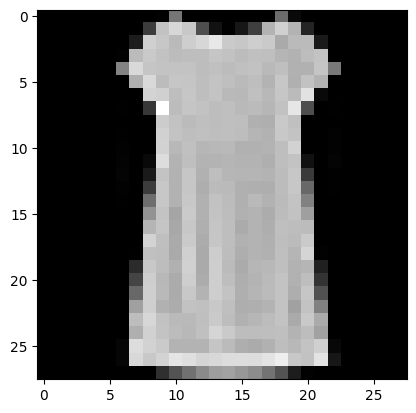

In [ ]:
for val in train_loader_pre:
  label = val[1][0]
  img = val[0][0]
  print("Label: " + str(label))
  print("Image Size: " + str(img.size()))
  plt.imshow(img.squeeze(), cmap='gray')
  input_dim = img.size()[1]**2
  break

## Autoencoder

In [ ]:
latent_dim = 2 ** n_qubits


class AE(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        input_dim = kwargs["input_dim"]
        encoder_dim = kwargs["encoder_dims"]
        latent_dim = kwargs["latent_dim"]
        self.encoder = nn.Sequential(OrderedDict([ ('fc1', nn.Linear(input_dim, encoder_dim[0])),
                                    ('act1', nn.ReLU()),
                                    ('fc2', nn.Linear(encoder_dim[0], encoder_dim[1])),
                                    ('act2', nn.ReLU()),
                                    ('fc3', nn.Linear(encoder_dim[1], latent_dim)) ,
                                    ('act3', nn.Sigmoid())
                                ]))
        
        self.decoder = nn.Sequential(OrderedDict([ ('fc1', nn.Linear(latent_dim, encoder_dim[1])),
                                    ('act1', nn.ReLU()),
                                    ('fc2', nn.Linear(encoder_dim[1], encoder_dim[0])),
                                    ('act2', nn.ReLU()),
                                    ('fc3', nn.Linear(encoder_dim[0], input_dim)),
                                    ('act3', nn.ReLU())
                                ]))

    def forward(self, features):
        encoded = self.encoder(features)
        decoded = self.decoder(encoded)
        return decoded

### Autoencoder Training

In [ ]:
epochs = 10
load_model = True
ae_model_path = "ae_model.pt"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = AE(input_dim=input_dim, latent_dim = latent_dim, encoder_dims = [196, 64]).to(device)
print(model)
if load_model:
  model.load_state_dict(torch.load(ae_model_path))

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

criterion = nn.MSELoss()

AE(
  (encoder): Sequential(
    (fc1): Linear(in_features=784, out_features=196, bias=True)
    (act1): ReLU()
    (fc2): Linear(in_features=196, out_features=64, bias=True)
    (act2): ReLU()
    (fc3): Linear(in_features=64, out_features=64, bias=True)
    (act3): Sigmoid()
  )
  (decoder): Sequential(
    (fc1): Linear(in_features=64, out_features=64, bias=True)
    (act1): ReLU()
    (fc2): Linear(in_features=64, out_features=196, bias=True)
    (act2): ReLU()
    (fc3): Linear(in_features=196, out_features=784, bias=True)
    (act3): ReLU()
  )
)


In [ ]:
model.train()
for epoch in range(epochs):
    loss = 0
    for batch_features, _ in train_loader_pre:
        batch_features = batch_features.view(-1, input_dim).to(device)
        optimizer.zero_grad()
        outputs = model(batch_features)
        train_loss = criterion(outputs, batch_features)
        train_loss.backward()
        optimizer.step()
        loss += train_loss.item()
    loss = loss / len(train_loader_pre)
    
    print("epoch : {}/{}, loss = {:.6f}".format(epoch + 1, epochs, loss))

epoch : 1/10, loss = 0.078682
epoch : 2/10, loss = 0.042452
epoch : 3/10, loss = 0.034718
epoch : 4/10, loss = 0.030777
epoch : 5/10, loss = 0.028331
epoch : 6/10, loss = 0.026394
epoch : 7/10, loss = 0.024858
epoch : 8/10, loss = 0.022774
epoch : 9/10, loss = 0.021766
epoch : 10/10, loss = 0.020589


### Data Encoding

In [ ]:
class EncoderOutputDataset(torch.utils.data.Dataset):
    def __init__(self, encoder_outputs, labels):
        self.encoder_outputs = encoder_outputs
        self.labels = labels

    def __getitem__(self, index):
        return self.encoder_outputs[index], self.labels[index]

    def __len__(self):
        return len(self.encoder_outputs)

In [ ]:
model.eval()
encoder_outputs = []
labels = []
with torch.no_grad():
  for batch_features, batch_labels in train_loader_pre:
      batch_features = batch_features.view(-1, input_dim).to(device)
      encoded_features = model.encoder(batch_features)
      encoder_outputs.append(encoded_features.squeeze())  # Store the encoder output
      labels.append(batch_labels)
    
  train_data = torch.cat(encoder_outputs, 0 )
  train_labels = torch.cat(labels, 0)

with torch.no_grad():
  for batch_features, batch_labels in test_loader_pre:
      batch_features = batch_features.view(-1, input_dim).to(device)
      encoded_features = model.encoder(batch_features)
      encoder_outputs.append(encoded_features.squeeze())  # Store the encoder output
      labels.append(batch_labels)
    
  test_data = torch.cat(encoder_outputs, 0 )
  test_labels = torch.cat(labels, 0)


train_set = EncoderOutputDataset(train_data, train_labels)
test_set = EncoderOutputDataset(test_data, test_labels)

train_set_loader = torch.utils.data.DataLoader(train_set, 
                                           batch_size=64,
                                           shuffle = True)


test_set_loader = torch.utils.data.DataLoader(test_set, 
                                           batch_size=64,
                                           shuffle = True)

## Variational Quantum Classifier with PennyLane

In [ ]:
import pennylane as qml
from pennylane import numpy as p_np

from pennylane.templates.state_preparations import MottonenStatePreparation
from pennylane.templates.layers import StronglyEntanglingLayers

### Circuit Definition

In [ ]:
dev = qml.device("default.qubit", wires = n_qubits)
weight_shapes = {"weights": (num_layers, n_qubits, 3)}

@qml.qnode(dev, interface='torch')
def circuit(inputs, weights):
  num_layers = weights.shape[0]
  n_qubits = weights.shape[1]
  weights_each_layer = torch.split(weights, num_layers, dim=0)
  # Input normalization
  inputs_1 = inputs / torch.sqrt(torch.sum(inputs ** 2, dim=-1).clamp(min=0.001))

  for i, W in enumerate(weights):
    # Data re-uploading technique
    if i % 2 == 0:
      MottonenStatePreparation(inputs_1, wires = range(n_qubits))
    
  # Neural network layer
  StronglyEntanglingLayers(weights_each_layer[0], wires=range(n_qubits))
  
  # Measurement return
  return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

In [ ]:
weights = torch.rand(weight_shapes["weights"])
print(qml.draw(circuit, expansion_strategy="device")(torch.rand(64), weights))

0: ──RY(1.71)─╭●───────────╭●───────────────╭●─────────────────────────╭●──────────────────────────
1: ──RY(1.49)─╰X──RY(0.09)─╰X─╭●────────────│─────────────╭●───────────│───────────────╭●──────────
2: ──RY(1.65)─────────────────╰X──RY(-0.04)─╰X──RY(-0.20)─╰X──RY(0.21)─╰X─╭●───────────│───────────
3: ──RY(1.44)─────────────────────────────────────────────────────────────╰X──RY(0.18)─╰X──RY(0.02)
4: ──RY(1.35)──────────────────────────────────────────────────────────────────────────────────────
5: ──RY(1.58)──────────────────────────────────────────────────────────────────────────────────────

───────────────╭●────────────────────────────────────────────────────╭●───────────────────────────
───────────────│──────────────────────────╭●─────────────────────────│────────────────────────────
──╭●───────────│────────────╭●────────────│────────────╭●────────────│───────────────╭●───────────
──╰X──RY(0.14)─╰X──RY(0.29)─╰X──RY(-0.16)─╰X──RY(0.07)─╰X──RY(-0.12)─╰X─╭●───────────│────────────
───

Quantum Neural Network Model

In [ ]:
class QVC(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        self.input_dim = kwargs["input_dim"]
        self.num_classes = kwargs["num_classes"]
        self.weight_shapes = kwargs["weight_shapes"]
        
        self.model = nn.Sequential(OrderedDict([ 
            ('quantum_layer', qml.qnn.TorchLayer(kwargs["qnode"], self.weight_shapes)),
            ('fc', nn.Linear(self.weight_shapes["weights"][1], self.num_classes))
        ]))

    def forward(self, input):
      return self.model(input)

In [ ]:
load_model = True
qvc_model_path = "qvc_model.pt"

qvc = QVC(input_dim = latent_dim, num_classes = len(reduced_classes), weight_shapes = weight_shapes, qnode = circuit).to(device)
criterion = nn.CrossEntropyLoss()
opt = torch.optim.Adam(qvc.parameters(), lr=1e-3)
print(qvc)

if load_model:
  qvc.load_state_dict(torch.load(qvc_model_path))



QVC(
  (model): Sequential(
    (quantum_layer): <Quantum Torch Layer: func=circuit>
    (fc): Linear(in_features=6, out_features=4, bias=True)
  )
)


### Training

In [ ]:
epochs = 1
qvc.train()
for epoch in range(epochs):
    loss = 0
    for batch_features, labels in train_set_loader:
        batch_features = batch_features.to(device)
        labels = labels.to(device)
        opt.zero_grad()
        outputs = qvc(batch_features)
        train_loss = criterion(outputs, labels)
        train_loss.backward(retain_graph = True)
        opt.step()
        loss += train_loss.item()
    loss = loss / len(train_set_loader)
    
    print("epoch : {}/{}, loss = {:.6f}".format(epoch + 1, epochs, loss))

epoch : 1/1, loss = 1.093315


In [ ]:
qvc.eval()
total_correct = 0
total_samples = 0

with torch.no_grad():
    for batch_features, labels in test_set_loader:
        batch_features = batch_features.to(device)
        labels = labels.to(device)
        outputs = qvc(batch_features)
        probabilities = torch.softmax(outputs, dim=1)
        _, predicted_labels = torch.max(probabilities, dim=1)
        total_samples += labels.size(0)
        total_correct += (predicted_labels == labels).sum().item()

accuracy = total_correct / total_samples
print("Test accuracy: {:.2f}%".format(accuracy * 100))

In [ ]:
torch.save(qvc.state_dict(), "qvc_model.pt")
torch.save(model.state_dict(), "ae_model.pt")